In [ ]:
# Samuel Göbel
# Master Thesis Data Science and Society
# Tilburg University

# Burnout Prediction Among Medical Students




# ------------------------------------------------------------------------------
# Experiment 1: Baseline Model Perfromance Imbalanced Data
# ------------------------------------------------------------------------------

In [ ]:
# TabNet and Optuna Hyperparameter tuning
!pip install pytorch-tabnet
!pip install optuna

In [ ]:
# Standard libraries
import random


# Data handling
import numpy as np
import pandas as pd


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Data preprocessing
from sklearn.preprocessing import StandardScaler


# Model selection & training
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_predict,
    train_test_split
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# Evaluation metrics
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)


# Imbalanced-learn
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE


# Deep learning & optimization
import optuna
import torch
from pytorch_tabnet.tab_model import TabNetClassifier


# Explainability
import shap


# Colab utilities
from google.colab import files

In [ ]:
# Experiment 1: ----------------------------------------------------------------
# Burnout classification baseline


# using the precprocessed clean data
data = pd.read_csv("/content/drive/MyDrive/Master Thesis 2025/BurnoutDataset/data_encoded_clean.csv")

codebook = pd.read_csv("/content/drive/MyDrive/Master Thesis 2025/BurnoutDataset/Codebook Carrard et al. 2022 MedTeach.csv", sep = ";")

In [ ]:
data.describe()

,mbi_ex,mbi_cy,mbi_ea,age_z,stud_h_log_z,jspe_z,qcae_cog_z,qcae_aff_z,amsp_z,erec_mean_z,cesd_log_z,stai_t_z,mbi_ea_rev,burnout,mbi_total
count,886.000000,886.000000,886.000000,8.860000e+02,8.860000e+02,8.860000e+02,8.860000e+02,8.860000e+02,8.860000e+02,8.860000e+02,8.860000e+02,8.860000e+02,886.000000,886.000000,886.000000
mean,16.878104,10.079007,24.207675,-2.205409e-17,-1.804426e-16,-7.137506e-16,7.217703e-17,1.759315e-16,-2.105163e-16,6.676375e-16,8.220161e-17,-6.215244e-17,11.792325,0.039503,38.749436
std,5.256025,4.592609,4.633675,1.000565e+00,1.000565e+00,1.000565e+00,1.000565e+00,1.000565e+00,1.000565e+00,1.000565e+00,1.000565e+00,1.000565e+00,4.633675,0.194899,11.919996
min,5.000000,4.000000,10.000000,-1.632032e+00,-3.587328e+00,-4.485076e+00,-3.278082e+00,-3.123249e+00,-3.436620e+00,-3.881646e+00,-3.610149e+00,-1.912713e+00,0.000000,0.000000,9.000000
25%,13.000000,6.000000,21.000000,-7.226103e-01,-5.275293e-01,-6.122207e-01,-6.892360e-01,-7.042065e-01,-6.312344e-01,-5.718443e-01,-5.529278e-01,-7.432881e-01,8.000000,0.000000,30.000000
50%,17.000000,9.000000,24.000000,-1.163293e-01,2.993451e-01,7.122433e-02,-8.009576e-02,4.011436e-02,-3.008032e-02,6.465577e-02,1.516056e-01,8.485024e-03,12.000000,0.000000,38.000000
75%,20.000000,13.000000,28.000000,4.899517e-01,7.202355e-01,7.546693e-01,6.813296e-01,7.844352e-01,7.213623e-01,7.011560e-01,7.157376e-01,6.767278e-01,15.000000,0.000000,46.750000
max,30.000000,24.000000,36.000000,8.068464e+00,1.497740e+00,2.121559e+00,2.661035e+00,2.459157e+00,2.374536e+00,2.483357e+00,1.757949e+00,2.848517e+00,26.000000,1.000000,78.000000


In [ ]:
# ------------------------------------------------------------------------------
# Overview Experiment 1:
# ------------------------------------------------------------------------------


# Target variable ‘burnout’, excluding any mbi-related variables

# Models to compare: logistic regression, dt, rf, svm, xgboost, and tabnet

# Stratified 80/20 train/test split

# Model training and hyperparameter tuning via 5 fold cross validation

# Evaluation via precision, recall, f1, cohen’s kappa, and roc-auc

# Confusion Matrix error analysis

# ------------------------------------------------------------------------------


In [ ]:
# Speciyfin Target 'burnout' ---------------------------


# Exlcuding all mbi-related variables
mbi_columns = ['mbi_ex', 'mbi_cy', 'mbi_ea', 'mbi_total', 'mbi_ea_rev']
df_filtered = data.drop(columns=mbi_columns)

# Defining faetures and target
X = df_filtered.drop(columns=['burnout'])
y = df_filtered['burnout']

# stratified train/test split: 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()

((708, 23),
 (178, 23),
 burnout
 0    680
 1     28
 Name: count, dtype: int64,
 burnout
 0    171
 1      7
 Name: count, dtype: int64)

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age_z         886 non-null    float64
 1   stud_h_log_z  886 non-null    float64
 2   jspe_z        886 non-null    float64
 3   qcae_cog_z    886 non-null    float64
 4   qcae_aff_z    886 non-null    float64
 5   amsp_z        886 non-null    float64
 6   erec_mean_z   886 non-null    float64
 7   cesd_log_z    886 non-null    float64
 8   stai_t_z      886 non-null    float64
 9   year_2        886 non-null    bool   
 10  year_3        886 non-null    bool   
 11  year_4        886 non-null    bool   
 12  year_5        886 non-null    bool   
 13  year_6        886 non-null    bool   
 14  sex_2         886 non-null    bool   
 15  sex_3         886 non-null    bool   
 16  part_1        886 non-null    bool   
 17  job_1         886 non-null    bool   
 18  health_2      886 non-null    

# Logistic Regression

In [ ]:
# ------------------------------------------------------------------------------
# Logistic Regression
# ------------------------------------------------------------------------------



# Difiing LogReg
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)



# hyperparameter grid
param_dist = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # needed for L1
}


# Cross-validation variable
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# hyperparameter tuning with RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)



# Fit model (training!)
search.fit(X_train, y_train)



# saving best hyperparams
best_params = search.best_params_
print("Best hyperparameters (no oversampling):", best_params)



# Retraining on full train set with best hyperparams
final_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
final_model.fit(X_train, y_train)



# Evaluate on TRAINING set
y_train_pred = final_model.predict(X_train)
y_train_proba = final_model.predict_proba(X_train)[:, 1]

print("\nTraining Performance (No Oversampling):")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train, y_train_pred):.4f}")



# Evaluate on TEST set
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("\nTest Performance (No Oversampling):")
print(classification_report(y_test, y_pred))
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters (no oversampling): {'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(0.23357214690901212)}

Training Performance (No Oversampling):
Precision: 0.1322
Recall: 0.8214
F1 Score: 0.2277
ROC AUC: 0.8809
Cohen’s Kappa: 0.1713

Test Performance (No Oversampling):
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       171
           1       0.10      0.57      0.17         7

    accuracy                           0.78       178
   macro avg       0.54      0.68      0.52       178
weighted avg       0.94      0.78      0.84       178

Precision: 0.0976
Recall: 0.5714
F1 Score: 0.1667
ROC AUC: 0.7151
Cohen’s Kappa: 0.1066

Confusion Matrix:
 [[134  37]
 [  3   4]]


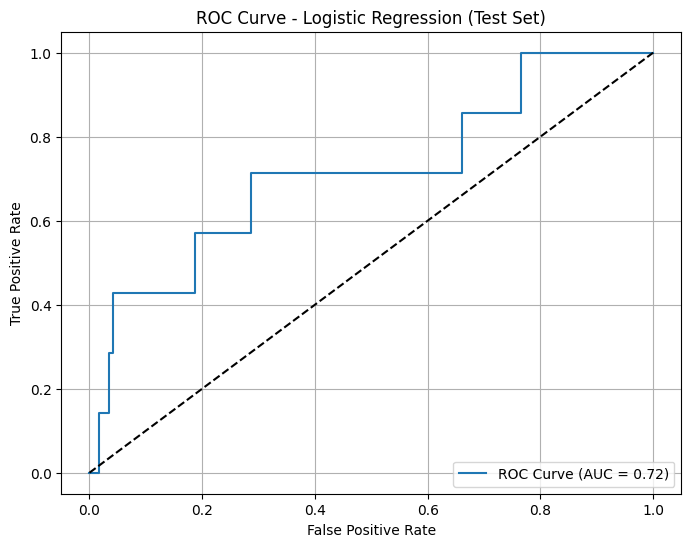

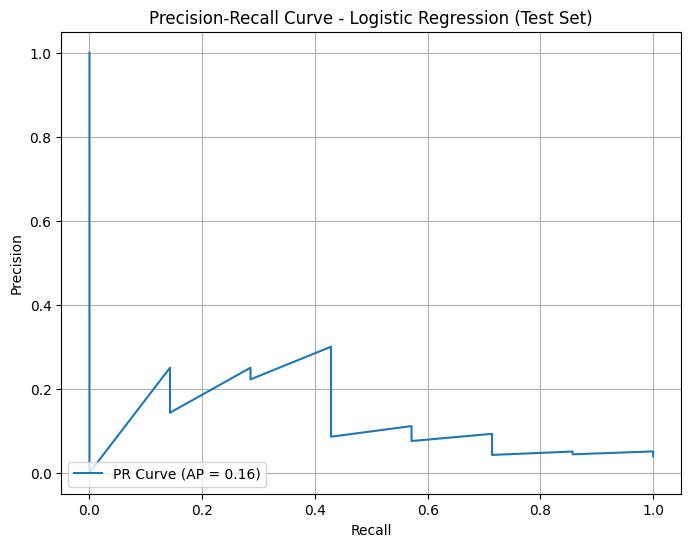

In [ ]:
# ROC-AUC Curve LOGISTIC REGRESSION


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# ------------------------------------------------------
# Precision-Recall (PR) Curve


precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression (Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# Decision Tree

In [ ]:
# ------------------------------------------------------------------------------
# Decision Tree
# ------------------------------------------------------------------------------




# Decsion Tree
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)



# Hyperparameter grid
param_dist = {
    'max_depth': [None] + list(np.arange(2, 21)),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'criterion': ['gini', 'entropy']
}



# Cross Val
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



# Hyperparm Tuning search
search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)



# Fit model
search.fit(X_train, y_train)




# print best hyperparams
best_params = search.best_params_
print("Best hyperparameters (DT - no oversampling):", best_params)



# TRain best model on whole train set
final_dt = DecisionTreeClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42
)
final_dt.fit(X_train, y_train)



# Evaluate on TRAINING set
y_train_pred = final_dt.predict(X_train)
y_train_proba = final_dt.predict_proba(X_train)[:, 1]

print("\nTraining Performance (DT - No Oversampling):")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train, y_train_pred):.4f}")

# Evaluate on TEST set
y_test_pred = final_dt.predict(X_test)
y_test_proba = final_dt.predict_proba(X_test)[:, 1]

print("\nTest Performance (DT - No Oversampling):")
print(classification_report(y_test, y_test_pred))
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test, y_test_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters (DT - no oversampling): {'min_samples_split': np.int64(10), 'min_samples_leaf': np.int64(11), 'max_depth': np.int64(20), 'criterion': 'entropy'}

Training Performance (DT - No Oversampling):
Precision: 0.2800
Recall: 1.0000
F1 Score: 0.4375
ROC AUC: 0.9686
Cohen’s Kappa: 0.4005

Test Performance (DT - No Oversampling):
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       171
           1       0.12      0.43      0.18         7

    accuracy                           0.85       178
   macro avg       0.54      0.65      0.55       178
weighted avg       0.94      0.85      0.89       178

Precision: 0.1154
Recall: 0.4286
F1 Score: 0.1818
ROC AUC: 0.6721
Cohen’s Kappa: 0.1278

Confusion Matrix:
 [[148  23]
 [  4   3]]


ROC AUC Score: 0.6721


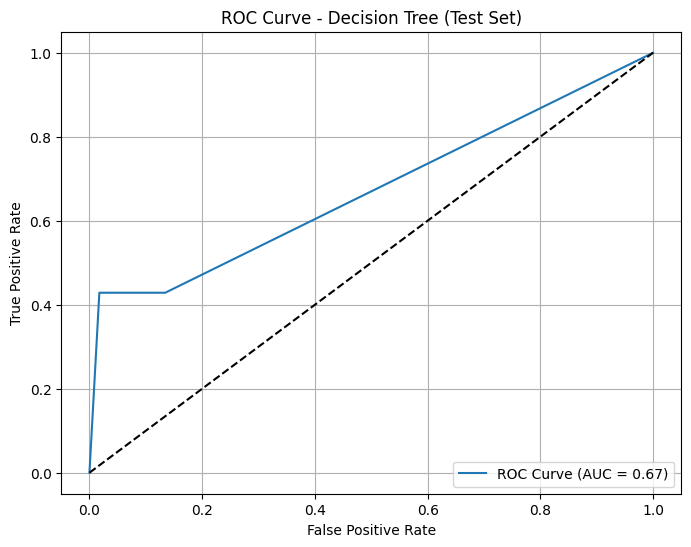

In [ ]:
# ROC-AUC for DECSION TREE
# ------------------------------------------------------------------------------



# DT with best hyperparams
best_DT_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=11,
    class_weight='balanced',
    random_state=42
)



# Fitting Model
best_DT_model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = best_DT_model.predict_proba(X_test)[:, 1]



# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")



# Plot AUC-ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


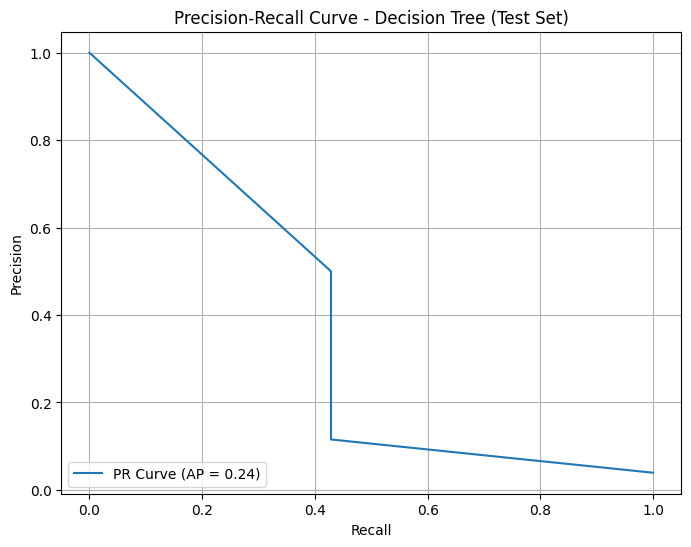

In [ ]:
# Precision Recall Curve DECISOIN TREE ----------------------------------------------------


# probabilities for the positive class
y_test_proba = best_DT_model.predict_proba(X_test)[:, 1]


# precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)


# Average Precision (AP) score
pr_auc = average_precision_score(y_test, y_test_proba)


# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree (Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# Random Forest

In [ ]:
# ------------------------------------------------------------------------------
# Random Forest
# ------------------------------------------------------------------------------




# RF Model
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)


# hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None] + list(np.arange(5, 21, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}


# cross val size
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



# Hyperparams seearch
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


# Fit on full training data
search.fit(X_train, y_train)



# best parameters RF
best_params = search.best_params_
print("Best hyperparameters (RF - no oversampling):", best_params)


# Retraining on full train with best params
final_rf = RandomForestClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
final_rf.fit(X_train, y_train)



# Evaluate on TRAINING set
y_train_pred = final_rf.predict(X_train)
y_train_proba = final_rf.predict_proba(X_train)[:, 1]

print("\nTraining Performance (RF - No Oversampling):")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train, y_train_pred):.4f}")

# Evaluate on TEST set
y_test_pred = final_rf.predict(X_test)
y_test_proba = final_rf.predict_proba(X_test)[:, 1]

print("\nTest Performance (RF - No Oversampling):")
print(classification_report(y_test, y_test_pred))
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test, y_test_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters (RF - no oversampling): {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': np.int64(5), 'criterion': 'entropy'}

Training Performance (RF - No Oversampling):
Precision: 0.7273
Recall: 0.8571
F1 Score: 0.7869
ROC AUC: 0.9943
Cohen’s Kappa: 0.7774

Test Performance (RF - No Oversampling):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       171
           1       0.40      0.29      0.33         7

    accuracy                           0.96       178
   macro avg       0.69      0.63      0.66       178
weighted avg       0.95      0.96      0.95       178

Precision: 0.4000
Recall: 0.2857
F1 Score: 0.3333
ROC AUC: 0.8864
Cohen’s Kappa: 0.3107

Confusion Matrix:
 [[168   3]
 [  5   2]]


ROC AUC Score: 0.8864


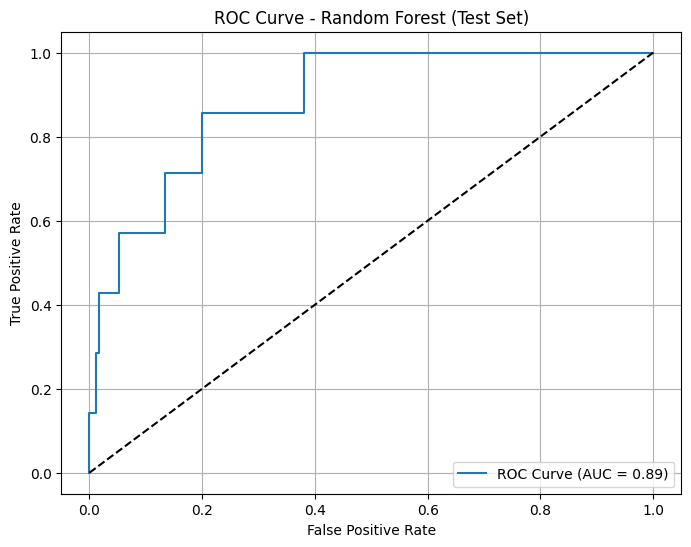

In [ ]:
# ROC-AUC Cruve for best RF Model
# ------------------------------------------------------------------------------



# RF model best params
final_rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=5,
    criterion='entropy',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


# Fit model
final_rf.fit(X_train, y_train)



# probabilities on the test set
y_test_proba = final_rf.predict_proba(X_test)[:, 1]



# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")



# plot roc-auc
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


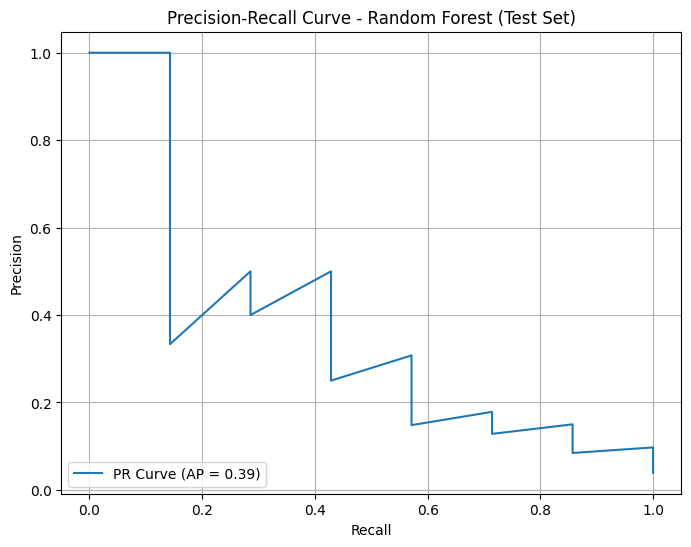

In [ ]:
# Precision Recall Curve RANDOM FORESST ----------------------------------------------------


# probabilities for the positive class
y_test_proba = final_rf.predict_proba(X_test)[:, 1]


# precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)


# Average Precision (AP) score
pr_auc = average_precision_score(y_test, y_test_proba)



# plot pr curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest (Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# Support Vector Machine

In [ ]:
# ------------------------------------------------------------------------------
# SVM
# ------------------------------------------------------------------------------





# defining SVM
svm = SVC(class_weight='balanced', probability=True, random_state=42)



# hyperparameter grid
param_dist = {
    'C': np.logspace(-3, 3, 10),
    'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 5)),
    'kernel': ['rbf', 'poly', 'sigmoid']  # 'linear' optional if you want simplicity
}



# cross-validation size
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



# Hyperparm search
search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)



# fit model on training set
search.fit(X_train, y_train)



# save best parameters
best_params = search.best_params_
print("Best hyperparameters (SVM - no oversampling):", best_params)



# retrain best model on full training set
final_svm = SVC(
    **best_params,
    class_weight='balanced',
    probability=True,
    random_state=42
)
final_svm.fit(X_train, y_train)




# Evaluate on TRAINING set
y_train_pred = final_svm.predict(X_train)
y_train_proba = final_svm.predict_proba(X_train)[:, 1]

print("\nTraining Performance (SVM - No Oversampling):")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train, y_train_pred):.4f}")






# Evaluate on TEST set
y_test_pred = final_svm.predict(X_test)
y_test_proba = final_svm.predict_proba(X_test)[:, 1]

print("\nTest Performance (SVM - No Oversampling):")
print(classification_report(y_test, y_test_pred))
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test, y_test_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters (SVM - no oversampling): {'kernel': 'rbf', 'gamma': 'scale', 'C': np.float64(0.46415888336127775)}

Training Performance (SVM - No Oversampling):
Precision: 0.3590
Recall: 1.0000
F1 Score: 0.5283
ROC AUC: 0.9910
Cohen’s Kappa: 0.4992

Test Performance (SVM - No Oversampling):
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       171
           1       0.21      0.57      0.31         7

    accuracy                           0.90       178
   macro avg       0.60      0.74      0.63       178
weighted avg       0.95      0.90      0.92       178

Precision: 0.2105
Recall: 0.5714
F1 Score: 0.3077
ROC AUC: 0.8789
Cohen’s Kappa: 0.2655

Confusion Matrix:
 [[156  15]
 [  3   4]]


ROC AUC Score: 0.8789


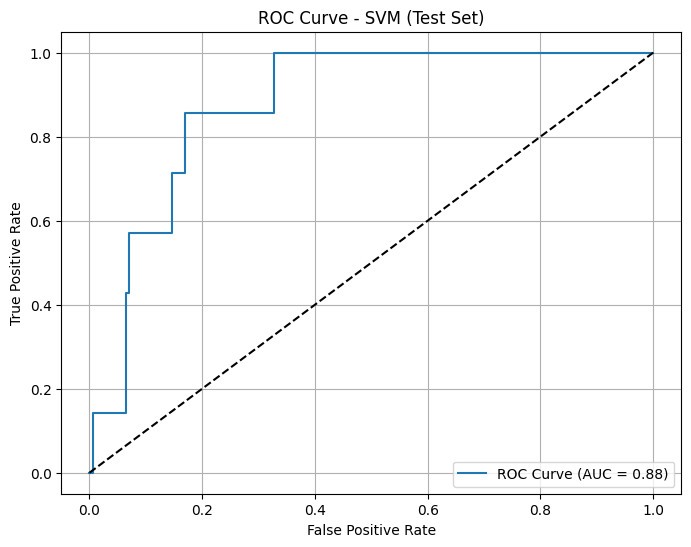

In [ ]:
# ROC-AUC visualization SuppVectMach
# ------------------------------------------------------------------------------




# SVM model with best hyperparameters
best_svm = SVC(
    kernel='rbf',
    gamma='scale',
    C=np.float64(0.46415888336127775),
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Fit model on training data
best_svm.fit(X_train, y_train)



# probabilitiest for test set
y_test_proba = best_svm.predict_proba(X_test)[:, 1]



# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")




# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


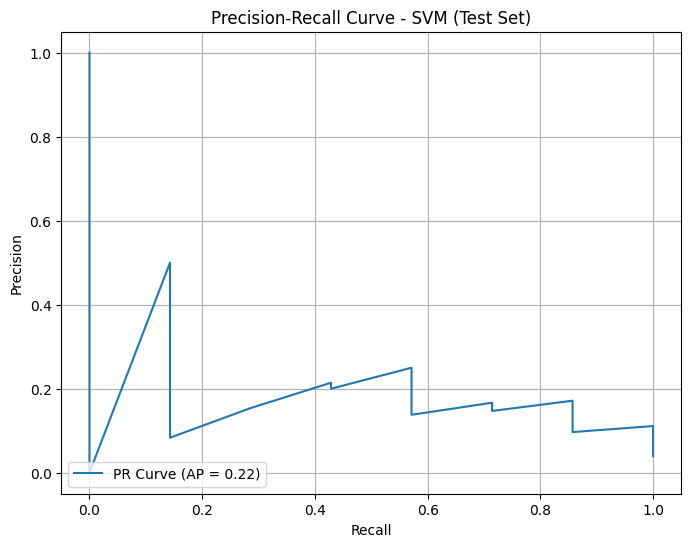

In [ ]:
# SVM Precision-Recall Curve---------------


# probabilities for the positive class
y_test_proba = best_svm.predict_proba(X_test)[:, 1]



# precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)


# Average Precision (AP) score
pr_auc = average_precision_score(y_test, y_test_proba)


# plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM (Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# XGBoost

In [ ]:
# ------------------------------------------------------------------------------
# XGBoost
# ------------------------------------------------------------------------------

# define XGB model
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # to handle imbalance
    random_state=42,
    n_jobs=-1
)



# hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2.0]
}



# cross val size
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)




# hyperparam search
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)



# fit model
search.fit(X_train, y_train)




# see best params
best_params = search.best_params_
print("Best hyperparameters (XGBoost - no oversampling):", best_params)



# retrain best model on full train set
final_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    random_state=42,
    n_jobs=-1,
    **best_params
)
final_xgb.fit(X_train, y_train)



# Evaluate on TRAINING set
y_train_pred = final_xgb.predict(X_train)
y_train_proba = final_xgb.predict_proba(X_train)[:, 1]

print("\nTraining Performance (XGBoost - No Oversampling):")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train, y_train_pred):.4f}")

# Evaluate on TEST set
y_test_pred = final_xgb.predict(X_test)
y_test_proba = final_xgb.predict_proba(X_test)[:, 1]

print("\nTest Performance (XGBoost - No Oversampling):")
print(classification_report(y_test, y_test_pred))
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test, y_test_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters (XGBoost - no oversampling): {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.8}

Training Performance (XGBoost - No Oversampling):
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Cohen’s Kappa: 1.0000

Test Performance (XGBoost - No Oversampling):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       171
           1       0.60      0.43      0.50         7

    accuracy                           0.97       178
   macro avg       0.79      0.71      0.74       178
weighted avg       0.96      0.97      0.96       178

Precision: 0.6000
Recall: 0.4286
F1 Score: 0.5000
ROC AUC: 0.8780
Cohen’s Kappa: 0.4831

Confusion Matrix:
 [[169   2]
 [  4   3]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:24:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:24:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:27:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC Score: 0.8780


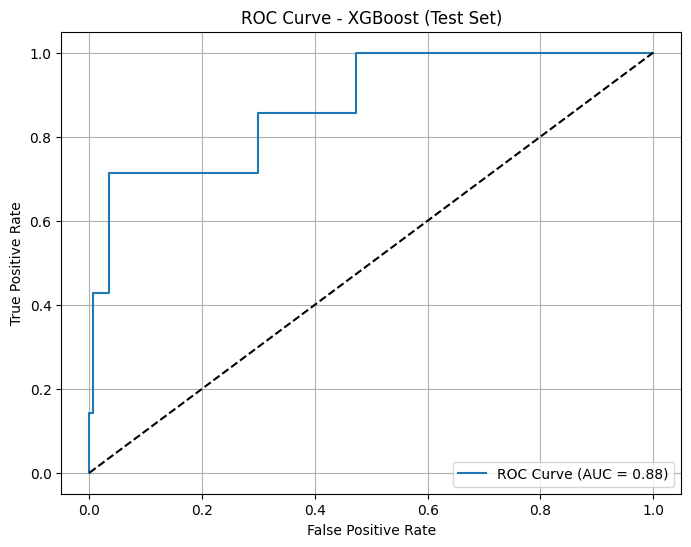

In [ ]:
# XGBoost ROC-AUC visualization
# ------------------------------------------------------------------------------




# XGB best param model
final_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    subsample=0.8,
    reg_lambda=1,
    reg_alpha=0,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.2,
    gamma=0,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)



# fit model
final_xgb.fit(X_train, y_train)




# predict probabilities for the test set
y_test_proba = final_xgb.predict_proba(X_test)[:, 1]





# compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")





# plot roc
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


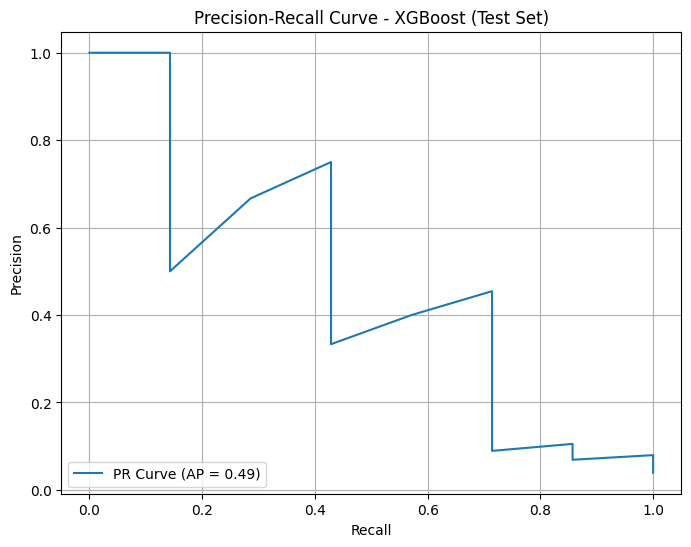

In [ ]:
# XGBoost PR- Curve ---------------------------






# precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)




# Average Precision (AP) score
ap_score = average_precision_score(y_test, y_test_proba)




# plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost (Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


# TabNet

In [ ]:
!pip install pytorch-tabnet
!pip install optuna # Hyperparameter tuning

  Using cached pytorch_tabnet-4.1.0-py3-none-any.whl.metadata (15 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-

In [ ]:
# ------------------------------------------------------------------------------
# TabNet
# ------------------------------------------------------------------------------







# ------------------------------------------------------
# Random Seed for reproducability
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
# ------------------------------------------------------








# ------------------------------------------------------
# preprocssing steps for data types:
# bool type not accepted.

X_train_fixed = X_train.copy()
X_test_fixed = X_test.copy()

bool_cols = X_train_fixed.select_dtypes(include='bool').columns
X_train_fixed[bool_cols] = X_train_fixed[bool_cols].astype(int)
X_test_fixed[bool_cols] = X_test_fixed[bool_cols].astype(int)

X_train_fixed = X_train_fixed.astype(np.float32)
X_test_fixed = X_test_fixed.astype(np.float32)

X_np = X_train_fixed.to_numpy()
y_np = y_train.to_numpy()

# ------------------------------------------------------






# Defining Optuna for Hyperparameter search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    set_seed(42)

    params = {
        'n_d': trial.suggest_int('n_d', 8, 64),
        'n_a': trial.suggest_int('n_a', 8, 64),
        'n_steps': trial.suggest_int('n_steps', 3, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
        'optimizer_params': dict(lr=trial.suggest_float('lr', 1e-4, 1e-1, log=True))
    }

    f1_scores = []

    for train_idx, val_idx in cv.split(X_np, y_np):
        X_tr, X_val = X_np[train_idx], X_np[val_idx]
        y_tr, y_val = y_np[train_idx], y_np[val_idx]

        model = TabNetClassifier(
            n_d=params['n_d'],
            n_a=params['n_a'],
            n_steps=params['n_steps'],
            gamma=params['gamma'],
            lambda_sparse=params['lambda_sparse'],
            optimizer_params=params['optimizer_params'],
            scheduler_params={"step_size": 10, "gamma": 0.9},
            scheduler_fn=torch.optim.lr_scheduler.StepLR,
            seed=42,
            verbose=0
        )

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric=['balanced_accuracy'],
            patience=10,
            max_epochs=100,
            batch_size=512,
            virtual_batch_size=128
        )

        preds = model.predict(X_val)
        f1_scores.append(f1_score(y_val, preds))

    return np.mean(f1_scores)









# ------------------------------------------------------
# Optuna optimization



optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))  # define seed same as everywhere else, for reproducability
study.optimize(objective, n_trials=30)

print("Best TabNet hyperparameters:", study.best_params)






# ------------------------------------------------------
# retrain best model on full train set



best_params = study.best_params

final_tabnet = TabNetClassifier(
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    optimizer_params=dict(lr=best_params['lr']),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    seed=42,
    verbose=0
)

final_tabnet.fit(
    X_np, y_np,
    eval_set=[(X_np, y_np)],  # train and validate on same training set
    eval_metric=['balanced_accuracy'],
    patience=10,
    max_epochs=100,
    batch_size=512,
    virtual_batch_size=128
)







# Evaluate on TRAINING Set
y_train_pred = final_tabnet.predict(X_np)
y_train_proba = final_tabnet.predict_proba(X_np)[:, 1]

print("\nTraining Performance (TabNet - No Oversampling):")
print(f"Precision: {precision_score(y_np, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_np, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_np, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_np, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_np, y_train_pred):.4f}")





# Evaluate on TEST Set
X_test_np = X_test_fixed.to_numpy()
y_test_np = y_test.to_numpy()

y_test_pred = final_tabnet.predict(X_test_np)
y_test_proba = final_tabnet.predict_proba(X_test_np)[:, 1]

print("\nTest Performance (TabNet - No Oversampling):")
print(classification_report(y_test_np, y_test_pred))
print(f"Precision: {precision_score(y_test_np, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test_np, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test_np, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_np, y_test_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test_np, y_test_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test_np, y_test_pred))



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.48039


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.59681


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.65441


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.70441


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.70809


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.73897


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.52819


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.57966


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.58897


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.57794


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.72917


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.58211


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.72794


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.65294


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.79534


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.53554


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.70147


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.69412


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.52574


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.52574


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.54044


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.55882


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.43309


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.65931


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_balanced_accuracy = 0.6


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.75123


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.51961


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.60172


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.61397


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.66103


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.52451


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.54485


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.72794


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.65196


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.64093


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.74191


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_balanced_accuracy = 0.75956


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.71814


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_balanced_accuracy = 0.60784


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.75368


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.56176


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.72794


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.65564


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.68137


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.69853


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.57426


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_balanced_accuracy = 0.58162


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.63358


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.65686


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.57794


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.6


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.58578


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.68015


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.59706


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.71544


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.56863


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_balanced_accuracy = 0.59632


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.49632


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.60049


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.6875


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.49632


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.58211


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.63725


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.71324


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.70074


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.60882


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.61152


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.54534


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.5576


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.59265


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.575


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.57598


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.57598


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.58333


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.77819


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.67402


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.66054


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_balanced_accuracy = 0.77794


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.6125


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.63358


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.7375


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.71936


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.56495


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.71324


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.58897


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.64559


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.67279


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.68137


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_balanced_accuracy = 0.63358


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.59632


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.58897


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.66544


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.72549


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.6299


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.61765


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_balanced_accuracy = 0.73015


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.57966


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.65564


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.69485


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_balanced_accuracy = 0.59632


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.6


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.63358


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.56495


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_balanced_accuracy = 0.5723


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.59632


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 15 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.54657


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_balanced_accuracy = 0.57598


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_balanced_accuracy = 0.69632


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.5576


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.56127


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.50245


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.54485


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.64093


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_balanced_accuracy = 0.65196


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.88235


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.61544


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 14 with best_epoch = 4 and best_val_0_balanced_accuracy = 0.5


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_balanced_accuracy = 0.5723


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.67402


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.60441


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.77941


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.7402


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.69118


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_balanced_accuracy = 0.58333


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_balanced_accuracy = 0.58897


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_balanced_accuracy = 0.69265
Best TabNet hyperparameters: {'n_d': 38, 'n_a': 21, 'n_steps': 10, 'gamma': 1.5742538165657438, 'lambda_sparse': 1.088347924473067e-06, 'lr': 0.01573936636608869}


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_balanced_accuracy = 0.5834

Training Performance (TabNet - No Oversampling):
Precision: 0.3846


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Recall: 0.1786
F1 Score: 0.2439
ROC AUC: 0.6954
Cohen’s Kappa: 0.2245

Test Performance (TabNet - No Oversampling):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       171
           1       0.67      0.29      0.40         7

    accuracy                           0.97       178
   macro avg       0.82      0.64      0.69       178
weighted avg       0.96      0.97      0.96       178

Precision: 0.6667
Recall: 0.2857
F1 Score: 0.4000
ROC AUC: 0.8095
Cohen’s Kappa: 0.3855

Confusion Matrix:
 [[170   1]
 [  5   2]]


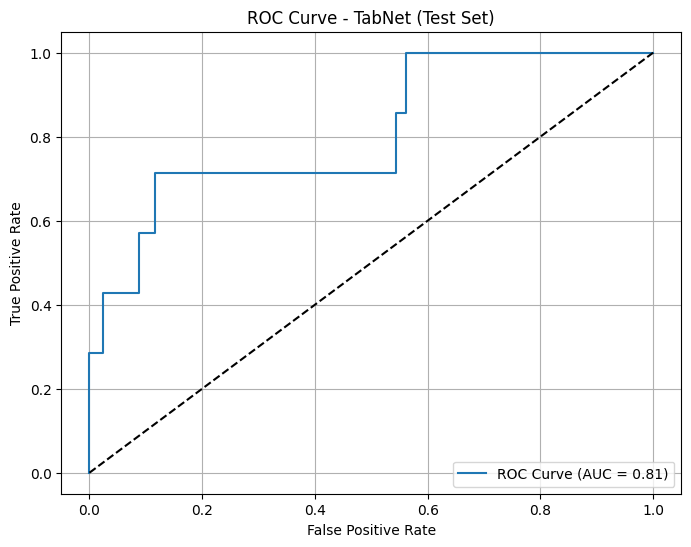

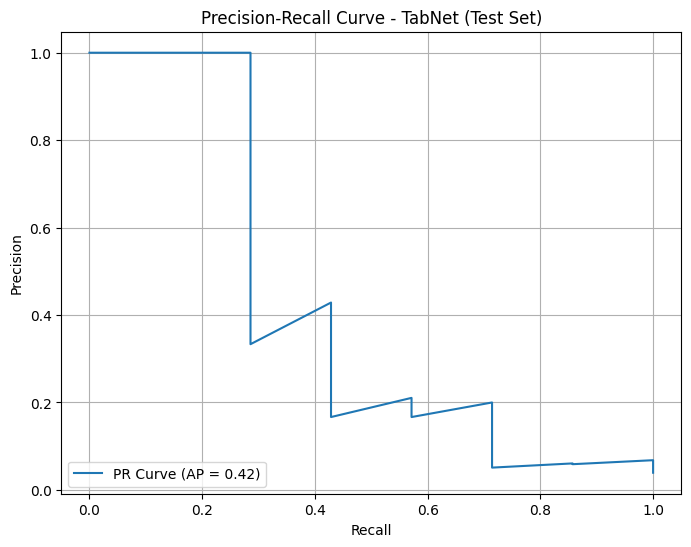

In [ ]:
# ------------------------------------------------------
# ROC-AUC Curve TABNET
# ------------------------------------------------------




fpr, tpr, thresholds = roc_curve(y_test_np, y_test_proba)
roc_auc = roc_auc_score(y_test_np, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TabNet (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





# ------------------------------------------------------
# Precision-Recall (PR) Curve

precision, recall, thresholds_pr = precision_recall_curve(y_test_np, y_test_proba)
ap_score = average_precision_score(y_test_np, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - TabNet (Test Set)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


         feature  importance
0          age_z    0.102303
1     qcae_cog_z    0.093050
2     cesd_log_z    0.088158
3         jspe_z    0.085740
4       stai_t_z    0.065378
5     qcae_aff_z    0.057690
6          sex_2    0.055899
7   stud_h_log_z    0.052315
8         amsp_z    0.049277
9         part_1    0.043814
10        psyt_1    0.038307
11   erec_mean_z    0.035385
12        year_4    0.033134
13        year_5    0.030143
14      health_2    0.026823
15        year_6    0.026437
16        year_3    0.024170
17        year_2    0.023905
18      health_4    0.023070
19      health_5    0.013026


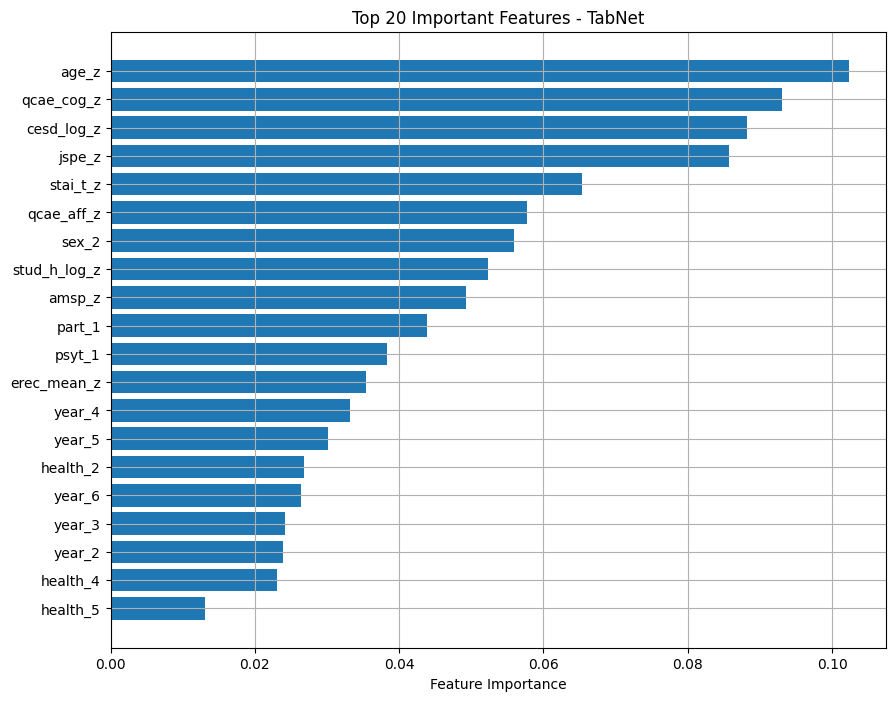

In [ ]:
# Feature Importance TabNet model
# ------------------------------------------------------



# define feature importances
feature_importances = final_tabnet.feature_importances_





# create DataFrame
feat_importance_df = pd.DataFrame({
    'feature': X_train_fixed.columns,
    'importance': feature_importances
})





# sort features
feat_importance_df = feat_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)




# print best features
print(feat_importance_df.head(20))




# Plot
plt.figure(figsize=(10, 8))
plt.barh(feat_importance_df['feature'][:20][::-1], feat_importance_df['importance'][:20][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features - TabNet')
plt.grid(True)
plt.show()


# Feature Importance Best Model


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:46:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


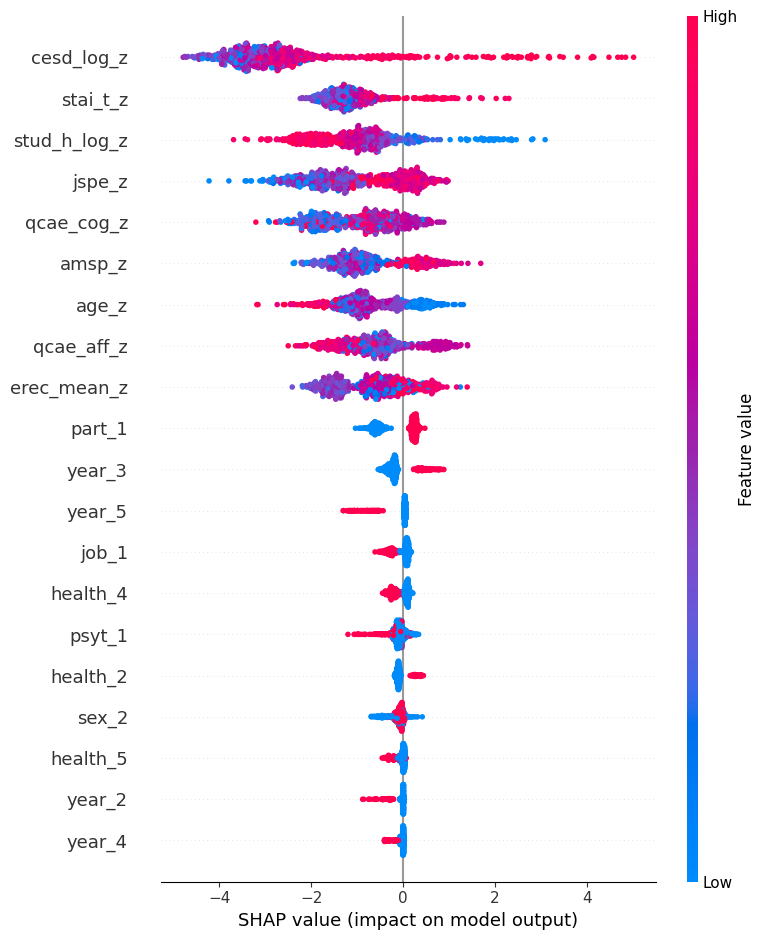

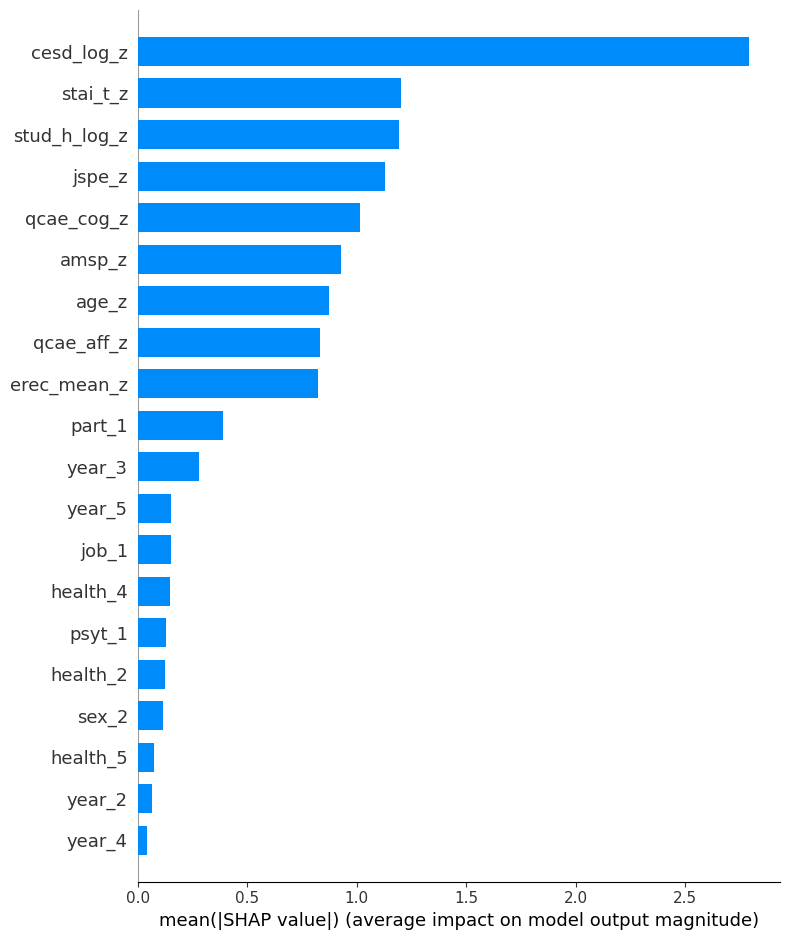


Training Performance (XGBoost):
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Cohen’s Kappa: 1.0000

Test Performance (XGBoost):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       171
           1       0.60      0.43      0.50         7

    accuracy                           0.97       178
   macro avg       0.79      0.71      0.74       178
weighted avg       0.96      0.97      0.96       178

Precision: 0.6000
Recall: 0.4286
F1 Score: 0.5000
ROC AUC: 0.8780
Cohen’s Kappa: 0.4831

Confusion Matrix:
 [[169   2]
 [  4   3]]


In [ ]:
# ------------------------------------------------------------------------------
# Best perfermong model Feature Importance
# ------------------------------------------------------------------------------



# XGB best overall Model for burnout classification.





# XGB best model
final_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    random_state=42,
    n_jobs=-1,
    subsample=0.8,
    reg_lambda=1,
    reg_alpha=0,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.2,
    gamma=0,
    colsample_bytree=0.8
)




# fit model
final_xgb.fit(X_train, y_train)







# ------------------------------------------------------------------------------
# SHAP Feature Importance
# ------------------------------------------------------------------------------



explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)




# Bar chart of average importance
shap.summary_plot(shap_values, X_train, plot_type="bar")








# ------------------------------------------------------------------------------
# Model Evaluation
# ------------------------------------------------------------------------------



# training set
y_train_pred = final_xgb.predict(X_train)
y_train_proba = final_xgb.predict_proba(X_train)[:, 1]

print("\nTraining Performance (XGBoost):")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_train, y_train_pred):.4f}")

# test set
y_test_pred = final_xgb.predict(X_test)
y_test_proba = final_xgb.predict_proba(X_test)[:, 1]

print("\nTest Performance (XGBoost):")
print(classification_report(y_test, y_test_pred))
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Cohen’s Kappa: {cohen_kappa_score(y_test, y_test_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


In [ ]:
# Inspect burn out and non-burn out cases--------



# Indices where y_test == 0
indices_class_0 = y_test[y_test == 0].index.tolist()

# Indices where y_test == 1
indices_class_1 = y_test[y_test == 1].index.tolist()

# Optional: print a few examples
print("Indices for class 0 (no burnout):", indices_class_0[:10])
print("Indices for class 1 (burnout):", indices_class_1[:10])


Indices for class 0 (no burnout): [51, 400, 414, 527, 788, 426, 640, 293, 109, 716]
Indices for class 1 (burnout): [606, 147, 278, 6, 702, 376, 29]


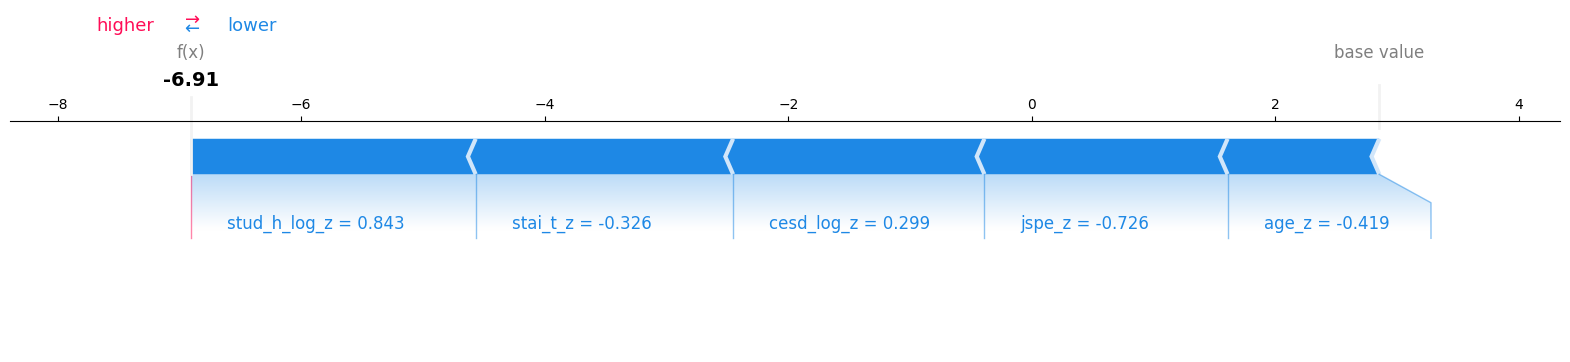

In [ ]:
# ------------------------------------------------------------------------------
# SHAP Force Plot non burnout
# ------------------------------------------------------------------------------



# Compute SHAP values
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_test)





# Choose non burnout sample by index
sample_index = 51
sample = X_test.iloc[sample_index]
sample_shap_values = shap_values[sample_index]





# create DataFrame with SHAP info
shap_df = pd.DataFrame({
    'feature': sample.index,
    'value': sample.values,
    'shap_value': sample_shap_values
})





# choose top 5 most important features
top_n = 5
shap_df['abs_shap'] = shap_df['shap_value'].abs()
top_features = shap_df.sort_values(by='abs_shap', ascending=False).head(top_n)






# ------------------------------
# Necessary for matplot lib visualization
# Format feature values: 3 decimals

def format_value(val):
    try:
        if np.isclose(val, 0) or np.isclose(val, 1):
            return str(int(round(val)))
        return f"{float(val):.3f}"
    except Exception:
        return str(val)

rounded_values = [format_value(v) for v in top_features['value'].values]


# Combine feature name and value: e.g., "age = 53.0"
combined_names = [
    f"{name} = {val}" for name, val in zip(top_features['feature'].values, rounded_values)
]

# ------------------------------




# plot SHAP force plot with matplotlib
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=top_features['shap_value'].values,
    features=[None]*len(combined_names),  # not used in matplotlib, so dummy
    feature_names=combined_names,
    matplotlib=True
)


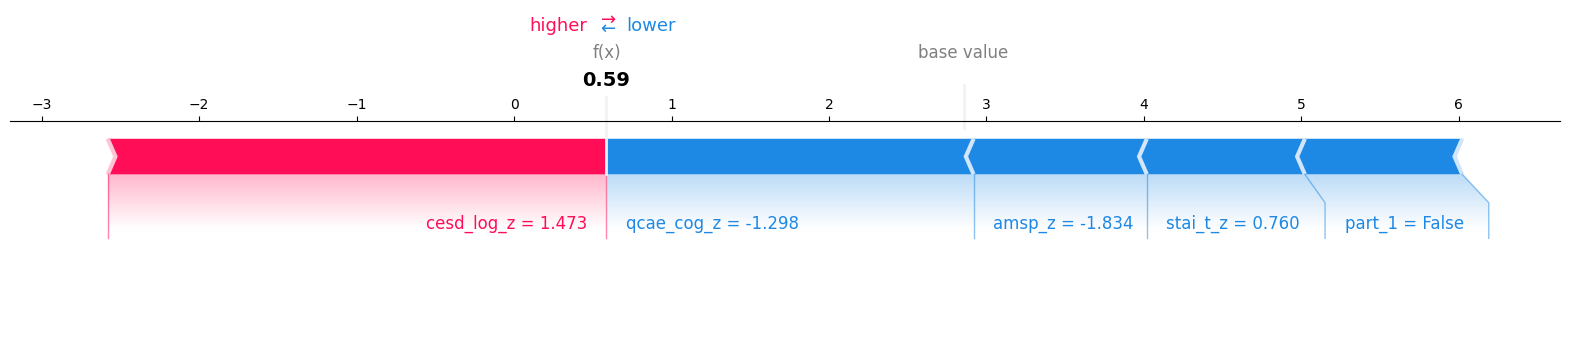

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ------------------------------------------------------------------------------
# SHAP Force Plot burnout
# ------------------------------------------------------------------------------






# Compute SHAP values
explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_test)




# Choose a burn out sample by index
sample_index = 147
sample = X_test.iloc[sample_index]
sample_shap_values = shap_values[sample_index]






# DataFrame with SHAP info
shap_df = pd.DataFrame({
    'feature': sample.index,
    'value': sample.values,
    'shap_value': sample_shap_values
})






# top 5 most important features
top_n = 5
shap_df['abs_shap'] = shap_df['shap_value'].abs()
top_features = shap_df.sort_values(by='abs_shap', ascending=False).head(top_n)





# -----------------------------------------------------------
# formatting for visualization
def format_value(val):
    try:
        if np.isclose(val, 0) or np.isclose(val, 1):
            return str(int(round(val)))
        return f"{float(val):.3f}"
    except Exception:
        return str(val)

rounded_values = [format_value(v) for v in top_features['value'].values]

# Combine feature name and value: e.g., "age = 53.0"
combined_names = [
    f"{name} = {val}" for name, val in zip(top_features['feature'].values, rounded_values)
]



# -----------------------------------------------------------






# plot SHAP force plot with matplotlib
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=top_features['shap_value'].values,
    features=[None]*len(combined_names),  # not used in matplotlib, so dummy
    feature_names=combined_names,
    matplotlib=True
)

